In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import io

In [18]:
# load detection
path = 'Filemail.com files 14.12.2023 fbhubejonusmcri/ADL-Rundle-6/det/det.txt'

# data
data = open(path, 'r').read()

# Column names as specified
column_names = ["frame", "id", "bb_left", "bb_top", "bb_width", "bb_height", "conf", "x", "y", "z"]

# Creating a DataFrame from the data
df = pd.read_csv(io.StringIO(data), names=column_names, header=None)
df.head(12)  # Displaying the first few rows of the DataFrame

,frame,id,bb_left,bb_top,bb_width,bb_height,conf,x,y,z
0,1,-1,1689,385,146.620,332.710,67.5670,-1,-1,-1
1,1,-1,1303,503,61.514,139.590,29.4390,-1,-1,-1
2,1,-1,1258,569,40.123,91.049,19.6010,-1,-1,-1
3,1,-1,31,525,113.370,257.270,17.0130,-1,-1,-1
4,1,-1,1800,483,94.660,214.810,11.9490,-1,-1,-1
5,2,-1,1689,385,146.620,332.710,66.7250,-1,-1,-1
6,2,-1,1312,503,61.514,139.590,36.6140,-1,-1,-1
7,2,-1,1744,476,123.420,280.060,16.9760,-1,-1,-1
8,2,-1,1254,537,52.000,118.000,15.9790,-1,-1,-1
9,2,-1,55,542,94.660,214.810,9.3326,-1,-1,-1


In [19]:
def compute_iou(boxA, boxB):
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

# Convert the bounding box from [left, top, width, height] to [x1, y1, x2, y2]
df['x1'] = df['bb_left']
df['y1'] = df['bb_top']
df['x2'] = df['bb_left'] + df['bb_width']
df['y2'] = df['bb_top'] + df['bb_height']



In [20]:
df_frame1 = df[df['frame'] == 1]
df_frame2 = df[df['frame'] == 2]

# Initialize an empty matrix for IoU between frame 1 and frame 2
iou_matrix_frame1_frame2 = pd.DataFrame(np.zeros((len(df_frame1), len(df_frame2))), index=df_frame1.index,
                                        columns=df_frame2.index)
# Compute IoU for each pair of bounding boxes between frame 1 and frame 2
for i in df_frame1.index:
    boxA = df_frame1.loc[i, ['x1', 'y1', 'x2', 'y2']]
    for j in df_frame2.index:
        boxB = df_frame2.loc[j, ['x1', 'y1', 'x2', 'y2']]
        iou_matrix_frame1_frame2.at[i, j] = compute_iou(boxA, boxB)

# display the IoU matrix
print(iou_matrix_frame1_frame2)

         5         6         7         8         9    10
0  1.000000  0.000000  0.361845  0.000000  0.000000  0.0
1  0.000000  0.744732  0.000000  0.021989  0.000000  0.0
2  0.000000  0.000000  0.000000  0.544377  0.000000  0.0
3  0.000000  0.000000  0.000000  0.000000  0.633519  0.0
4  0.124487  0.000000  0.358332  0.000000  0.000000  0.0


In [21]:
sigma_iou = 0.5

# Function to associate detections to tracks using IoU
def associate_detections_to_tracks(iou_matrix, sigma_iou):
    associations = {}

    for track_idx in iou_matrix.index:
        # Find the detection with the highest IoU for this track
        best_detection_idx = iou_matrix.loc[track_idx].idxmax()
        best_iou = iou_matrix.loc[track_idx, best_detection_idx]

        # Associate the detection to the track if IoU is above the threshold
        if best_iou >= sigma_iou:
            associations[track_idx] = best_detection_idx

    return associations

# Associate detections of frame 2 to tracks of frame 1
associations_frame1_frame2 = associate_detections_to_tracks(iou_matrix_frame1_frame2, sigma_iou)
associations_frame1_frame2


{0: 5, 1: 6, 2: 8, 3: 9}

In [22]:
# Initialize lists for matches, unmatched detections, and unmatched tracks
matches = []
unmatched_detections = list(df_frame2.index)
unmatched_tracks = list(df_frame1.index)

# Populate the lists based on the associations
for track_idx, detection_idx in associations_frame1_frame2.items():
    if detection_idx in unmatched_detections:
        # Add to matches and remove from unmatched lists
        matches.append((track_idx, detection_idx))
        unmatched_detections.remove(detection_idx)
    unmatched_tracks.remove(track_idx)

# Matches, unmatched detections, and unmatched tracks after processing
matches, unmatched_detections, unmatched_tracks


([(0, 5), (1, 6), (2, 8), (3, 9)], [7, 10], [4])

In [23]:
def track_management_with_unique_ids(df, frame_range, sigma_iou):
    # Initialize a dictionary to store the results for each frame and a counter for unique IDs
    results = {}
    current_ids = {}  # Mapping from index to current IDs
    next_id = 0  # The next unique ID to be assigned

    # Process each pair of consecutive frames within the specified range
    for frame in range(frame_range[0], frame_range[1]):
        # Filter data for the current pair of frames
        df_current_frame = df[df['frame'] == frame]
        df_next_frame = df[df['frame'] == frame + 1]

        # Skip if either frame has no detections
        if df_current_frame.empty or df_next_frame.empty:
            continue

        # Initialize an empty matrix for IoU between the current and next frames
        iou_matrix = pd.DataFrame(index=df_current_frame.index, columns=df_next_frame.index)

        # Compute IoU for each pair of bounding boxes
        for i in df_current_frame.index:
            boxA = df_current_frame.loc[i, ['x1', 'y1', 'x2', 'y2']]
            for j in df_next_frame.index:
                boxB = df_next_frame.loc[j, ['x1', 'y1', 'x2', 'y2']]
                iou_matrix.at[i, j] = compute_iou(boxA, boxB)

        # Convert the IoU values in the matrix to floats
        iou_matrix = iou_matrix.apply(pd.to_numeric)

        # Associate detections of the next frame to tracks of the current frame
        associations = associate_detections_to_tracks(iou_matrix, sigma_iou)

        # Initialize lists for matches, unmatched detections, and unmatched tracks
        matches = []
        unmatched_detections = list(df_next_frame.index)
        unmatched_tracks = list(df_current_frame.index)

        # Populate the lists based on the associations
        for track_idx, detection_idx in associations.items():
            if detection_idx in unmatched_detections:
                # If we have an existing ID for the track, keep it; otherwise, assign a new ID
                track_id = current_ids.get(track_idx, next_id)
                current_ids[detection_idx] = track_id  # Carry over the ID to the associated detection
                matches.append((track_id, detection_idx))
                unmatched_detections.remove(detection_idx)
                if track_idx not in current_ids:
                    next_id += 1  # Increment the ID counter if a new ID was assigned
            # No longer need to remove from unmatched_tracks because we are not reusing these indices

        # Assign new IDs to unmatched detections
        for detection_idx in unmatched_detections:
            current_ids[detection_idx] = next_id
            next_id += 1

        # Remove unmatched tracks (we assume they are no longer present)
        for track_idx in unmatched_tracks:
            if track_idx in current_ids:
                del current_ids[track_idx]

        # Store results for the current frame
        results[frame] = {
            'matches': matches,
            'unmatched_detections': unmatched_detections,
            'unmatched_tracks': unmatched_tracks
        }

    return results, next_id  # Return the results and the next unique ID

# Apply the modified track management to our data
frame_range = (1, 10)  # Range of frames to process
track_management_results, _ = track_management_with_unique_ids(df, frame_range, sigma_iou)
track_management_results  # Displaying the updated results and current IDs




{1: {'matches': [(0, 5), (1, 6), (2, 8), (3, 9)],
  'unmatched_detections': [7, 10],
  'unmatched_tracks': [0, 1, 2, 3, 4]},
 2: {'matches': [(0, 12), (1, 13), (4, 14), (3, 17)],
  'unmatched_detections': [11, 15, 16],
  'unmatched_tracks': [5, 6, 7, 8, 9, 10]},
 3: {'matches': [(6, 19), (0, 18), (1, 21), (8, 22), (3, 23)],
  'unmatched_detections': [20],
  'unmatched_tracks': [11, 12, 13, 14, 15, 16, 17]},
 4: {'matches': [(0, 24), (9, 25), (1, 26)],
  'unmatched_detections': [27],
  'unmatched_tracks': [18, 19, 20, 21, 22, 23]},
 5: {'matches': [(0, 28), (9, 29), (1, 31)],
  'unmatched_detections': [30, 32, 33],
  'unmatched_tracks': [24, 25, 26, 27]},
 6: {'matches': [(0, 34), (9, 35), (11, 36)],
  'unmatched_detections': [37, 38, 39],
  'unmatched_tracks': [28, 29, 30, 31, 32, 33]},
 7: {'matches': [(0, 40), (9, 42), (11, 41)],
  'unmatched_detections': [43, 44],
  'unmatched_tracks': [34, 35, 36, 37, 38, 39]},
 8: {'matches': [(0, 45), (11, 46), (9, 47), (18, 51)],
  'unmatched_de

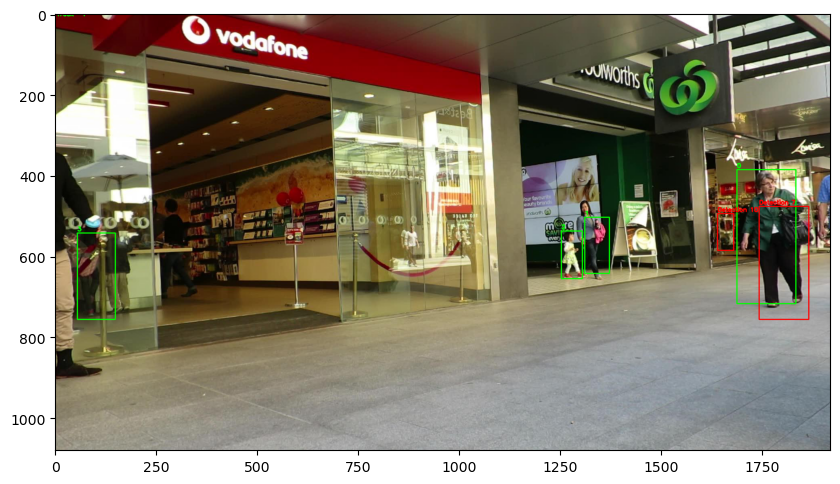

In [24]:
# Function to draw bounding boxes, IDs, and trajectories
def draw_tracking_info(image, matches, unmatched_detections, unmatched_tracks):
    # Define colors
    color_matched = (0, 255, 0)  # Green for matched
    color_unmatched_detection = (0, 0, 255)  # Red for unmatched detection
    color_unmatched_track = (255, 0, 0)  # Blue for unmatched track
    
    # Draw matched tracks
    for track_idx, detection_idx in matches:
        # Get the bounding box of the detection
        bb_left = int(df.loc[detection_idx, 'bb_left'])
        bb_top = int(df.loc[detection_idx, 'bb_top'])
        bb_width = int(df.loc[detection_idx, 'bb_width'])
        bb_height = int(df.loc[detection_idx, 'bb_height'])
        
        # Draw the bounding box
        cv2.rectangle(image, (bb_left, bb_top), (bb_left + bb_width, bb_top + bb_height), color_matched, 2)
        
        # Annotate the bounding box with the track ID
        cv2.putText(image, str(track_idx), (bb_left, bb_top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_matched, 2)
        
        # Get the centroid of the detection
        cx = int(df.loc[detection_idx, 'x'])
        cy = int(df.loc[detection_idx, 'y'])
        
        # Draw the centroid
        cv2.circle(image, (cx, cy), 2, color_matched, 2)
        
        # Get the track ID
        track_id = int(df.loc[track_idx, 'id'])
        
        # Annotate the image with the track ID
        cv2.putText(image, 'Track ' + str(track_id), (cx + 5, cy + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_matched, 2)

    # Draw unmatched detections
    for detection_idx in unmatched_detections:
        # Get the bounding box of the detection
        bb_left = int(df.loc[detection_idx, 'bb_left'])
        bb_top = int(df.loc[detection_idx, 'bb_top'])
        bb_width = int(df.loc[detection_idx, 'bb_width'])
        bb_height = int(df.loc[detection_idx, 'bb_height'])
        
        # Draw the bounding box
        cv2.rectangle(image, (bb_left, bb_top), (bb_left + bb_width, bb_top + bb_height), color_unmatched_detection, 2)
        
        # Annotate the bounding box with the detection ID
        cv2.putText(image, 'Detection ' + str(detection_idx), (bb_left, bb_top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_unmatched_detection, 2)

    
    
    return image

# Load the first frame of the video
image = cv2.imread('Filemail.com files 14.12.2023 fbhubejonusmcri/ADL-Rundle-6/img1/000001.jpg')
height, width, channels = image.shape

# Draw the tracking info on the image
image = draw_tracking_info(image, track_management_results[1]['matches'], 
        track_management_results[1]['unmatched_detections'], 
        track_management_results[1]['unmatched_tracks'])

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()


In [25]:
# do it on the whole video and display it in time frame by frame with cv2.imshow
frame_range = (1, 500)

# Load all the frames of the video
frames = []
for frame in range(frame_range[0], frame_range[1] + 1):
    image = cv2.imread('Filemail.com files 14.12.2023 fbhubejonusmcri/ADL-Rundle-6/img1/{:06d}.jpg'.format(frame))
    frames.append(image)

# computes the tracks on the whole video
track_management_results_updated, ids = track_management_with_unique_ids(df, frame_range, sigma_iou)
print(track_management_results_updated)

{1: {'matches': [(0, 5), (1, 6), (2, 8), (3, 9)], 'unmatched_detections': [7, 10], 'unmatched_tracks': [0, 1, 2, 3, 4]}, 2: {'matches': [(0, 12), (1, 13), (4, 14), (3, 17)], 'unmatched_detections': [11, 15, 16], 'unmatched_tracks': [5, 6, 7, 8, 9, 10]}, 3: {'matches': [(6, 19), (0, 18), (1, 21), (8, 22), (3, 23)], 'unmatched_detections': [20], 'unmatched_tracks': [11, 12, 13, 14, 15, 16, 17]}, 4: {'matches': [(0, 24), (9, 25), (1, 26)], 'unmatched_detections': [27], 'unmatched_tracks': [18, 19, 20, 21, 22, 23]}, 5: {'matches': [(0, 28), (9, 29), (1, 31)], 'unmatched_detections': [30, 32, 33], 'unmatched_tracks': [24, 25, 26, 27]}, 6: {'matches': [(0, 34), (9, 35), (11, 36)], 'unmatched_detections': [37, 38, 39], 'unmatched_tracks': [28, 29, 30, 31, 32, 33]}, 7: {'matches': [(0, 40), (9, 42), (11, 41)], 'unmatched_detections': [43, 44], 'unmatched_tracks': [34, 35, 36, 37, 38, 39]}, 8: {'matches': [(0, 45), (11, 46), (9, 47), (18, 51)], 'unmatched_detections': [48, 49, 50], 'unmatched_t

In [26]:
# imshow for each frame
for frame in range(frame_range[0], frame_range[1]):
    # Load the frame
    image = frames[frame - frame_range[0]]

    # Draw the tracking info on the image
    image = draw_tracking_info(image, track_management_results_updated[frame]['matches'], 
        track_management_results_updated[frame]['unmatched_detections'], 
        track_management_results_updated[frame]['unmatched_tracks'])
    # Display the image
    cv2.imshow('Frame', image)
    cv2.waitKey(10)

cv2.destroyAllWindows()

In [27]:
#print nb of obj at the end of the video
print(ids)

1218
